<a href="https://colab.research.google.com/github/bryang229/Grover_for_four_colors/blob/main/Copy_of_QXQ_EQCI_Homework_6_%5BSTUDENT%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Grover's Algorithm for Graph Coloring Problems**
---

## **Introduction** 
This notebook will teach you how to use Grover's algorithm for more advanced problems known as Graph Coloring Problems. You will learn how to build your own an oracle and solve several types of problems that can all be reduced to Graph Coloring.

<br>

## **Description**
In Computer Science, Graph Coloring is one of many so-called "graph problems". Although the mathematical representation and analysis of these problems can get very complex, graph coloring is actually pretty simple. **We can view graph coloring as trying to answer the question, "Can we color every country on a map without any touching countries having the same color, given *k* colors?"**

<br>

It turns out that this problem is extremely powerful and can be used to represent many other problems including:
* Sudoku (numbers instead of colors in a 9X9 map)
* Scheduling
* Networking
* Machine Learning (ex: clustering)

Therefore, solving such a problem is very important!

<br>

We will see how to use Grover's algorithm for this problem, particularly learning how to use Grover to search of a *list of solutions* instead of through a literal databse. This is actually believed to be the more likely use of Grover once we have fault tolerant computers, due to the difficulty of encoding databases into quantum states in part.

We will follow these steps for building and solving a problem with Grover:
1. Create an initial state preparation circuit. This will put all possible solutions in equal superposition.
1. Create an oracle circuit. This will flip the phase of correct solutions and leave the rest alone. Defining this is often the hardest part.
1. Define the problem using Qiskit's `Amplification(...)` function.
1. Solve the problem using Qiskit's `Grover(...)` function. We usually have to run several times with different number of iterations to get a good result.



**NOTE**: This notebook will involve looking at many histograms of results. As the size of the problems increase, so will the number of solutions we see in our graphs. If you start having trouble seeing the individual bars and states in the graphs, you can click on them to zoom in OR right click and press "Save Image As..." to download onto your computer and open it up in a larger window.

<br>

## **Key Questions**
In this notebook, you will answer the following questions:
1. When using Grover's algorithm, we do not get good results for too few *or* too many iterations. Rather, there is a "sweet spot" (a balanced number of iterations) right in the middle. Why is this?
2. How and why does having *multiple* correct answers change the number of iterations needed for Grover's algorithm?


<br>

## **Structure**
This project is broken into 2 parts:

> **Part 1**: Grover for 2 Coloring Problems
>
>> **Part 1.1**: Building a Specific Problem
>>
>> **Part 1.2**: Building General Problems
>>
>> **Part 1.3**: Solving General Problems
>
> **Part 2**: A Mathematical Formulation of Grover's Algorithm
>
>>**Part 2.1**: Ket Representation
>>
>>**Part 2.2**: Vector Representation
>
> **Wrapping Up**

<br>

## **Resources**

* [Qiskit Textbook: Grover for Sudoku](https://qiskit.org/textbook/ch-algorithms/grover.html#sudoku)
* [Qiskit Documentation: Grover’s Algorithm and Amplitude Amplification](https://qiskit.org/documentation/tutorials/algorithms/06_grover.html)
* [Qiskit Documentation: `AmplificationProblem(...)`](https://qiskit.org/documentation/stubs/qiskit.algorithms.AmplificationProblem.html)
* [Qiskit Documentation: `Grover(...)`](https://qiskit.org/documentation/stubs/qiskit.algorithms.Grover.html)
* [Qiskit Documentation: `circuit.mct(...)`](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.mct.html)
* [Original Paper on Grover's Algorithm](https://arxiv.org/pdf/quant-ph/9605043.pdf)

**If you're curious to learn more:**
* [Youtube: The Four Color Theorem - What Counts as a Proof?](https://www.youtube.com/watch?v=42-ws3bkrKM)

<br>

**Run the cell below to import all necessary functions, libraries, and code.**

In [ ]:
!pip install qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.circuit import AncillaQubit
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover

#provider = IBMQ.load_account()

#import math
#from qiskit.quantum_info import Statevector

import warnings
warnings.filterwarnings('ignore')



def plot_results(result, satisfies_disagree_list):

  # Plotting results
  counts = result.circuit_results[0]
  plot = plot_histogram(counts, figsize=(int(6*len(counts.keys())**(1/2)), 8), sort='value_desc')
  ax = plot.gca()
  ax.tick_params(axis='x', which='major', labelsize=10)
  ax.set_xlabel("State", fontsize = 'x-large')
  ax.set_ylabel("Count", fontsize = 'x-large')

  # Marking correct (orange) vs. incorrect (blue) states

  correct_count = 0
  states = ax.xaxis.get_ticklabels()
  for i in range(len(states)):
    if satisfies_disagree_list(states[i].get_text()):
      ax.containers[i][0].set(color = 'orange')
      correct_count += 1
    else:
      ax.containers[i][0].set(color = 'blue')

  leg = plot.legend(['Incorrect (' + str(len(states) - correct_count) + ' counted)', 
                     'Correct (' + str(correct_count) + ' counted)'], 
                    fontsize = 'x-large',
                    loc = 'upper left')
  leg.legendHandles[0].set_color('blue')
  leg.legendHandles[1].set_color('orange')

  display(plot)


print("Libraries Imported Successfully!")

---
## **Part 1: Grover for 2 Coloring Problems**
---

In this section, we will learn how to use Grover's algorithm to solve the 2 Coloring Problem. In other words, we are trying to color a map with just 2 colors available, which we will choose to be black and white. We will do so through these parts:

**Part 1.1**: Building a Specific Problem

**Part 1.2**: Building General Problems

**Part 1.3**: Solving General Problems

---
### **Part 1.1: Building a Specific Problem**
---

In this section, we will build and solve a specific 2 coloring problem: two bordering countries with two colors.

**Country 0 | Country 1**

<br>

Therefore, the correct answers are:

**White | Black**

**Black | White**

And the incorrect answers are:

**White | White**

**Black | Black**

<br>

We will use the following representation:

* Each country is represented by a qubit.
* When a qubit is 0, that country is colored white.
* When a qubit is 1, that country is colored black.

This means that the correct solutions correspond to 01 (white and black) and 10 (black and white) where the incorrect solutions correspond to 00 (white and white) and 11 (black and black).


<br>

Lastly, we will follow these steps for building and solving this problem with Grover:
1. Create an initial state preparation circuit. This will put all possible solutions in equal superposition.
1. Create an oracle circuit. This will flip the phase of correct solutions and leave the rest alone. Defining this is often the hardest part.
1. Define the problem using Qiskit's `Amplification(...)` function.
1. Solve the problem using Qiskit's `Grover(...)` function. We usually have to run several times with different number of iterations to get a good result.

<br>

**NOTE**: We will provide you a lot of guidance in this section so that you can focus on implementing the code first. Then, we recommend you go back over this part to really understand it upon a second look.

#### **Step #1: Create an initial state preparation circuit.**

This circuit needs to create an equal superposition of all possible solutions. Therefore, complete the code below so that:
* There is 1 qubit per country and no classical bits.
* Each qubit is put into superposition.

In [ ]:
prep = QuantumCircuit(# COMPLETE THIS LINE
                      
prep.# COMPLETE THIS CODE


prep.draw()

#### **Step #2: Create an oracle circuit.**

We need to define a circuit that will flip the phase of correct solutions and leave the rest alone. In this particular case, that means:

* If the two qubits disagree with each other (01 or 10), then we should flip the phase.
* Otherwise (00 or 11), leave the phase alone.

In order to implement this, we will use two extra qubits:
* 1 qubit that says there's a valid solution (01 or 10) by flipping to 1.
* **The "output" bit**: 1 qubit that marks the state by flipping the phase, specifically changing from  $|-\rangle$ to $-|-\rangle$.

This is broken down into 3 parts:
1. Initialize the oracle circuit.
1. Check if the current state is a solution.
1. Reset the extra bit for the next iteration.

##### **1. Initialize the oracle circuit.**

Specifically, create a circuit such that:
* There's 4 qubits and no classical bits.
* The last qubit, $q_3$, is put into the $|-\rangle$ state.

In [ ]:
oracle = # COMPLETE THIS LINE
oracle.# COMPLETE THIS LINE
oracle.# COMPLETE THIS LINE

##### **2. Check if the current state is a solution.**

Specifically, apply gates as follows:
* **Flip $q_2$ if $q_0$ and $q_1$ disagree**: CX controlled by $q_0$ and targeting $q_2$ and a CX controlled by $q_1$ and targeting $q_2$. Technically, this calculates $q_2$ = XOR($q_0$, $q_1$).
* **Flip $q_3$ if $q_2$ has been activated**: CX controlled by $q_2$ and targeting $q_3$.

**NOTE**: Before continuing, it is worth using pen, paper, and kets to understand how these gates accomplish their purposes stated above.

In [ ]:
# Flip qubit 2 if qubits 0 and 1 disagree
oracle.# COMPLETE THIS LINE
oracle.# COMPLETE THIS LINE

# Flip qubit 3 if qubit 2 has been activated
oracle.# COMPLETE THIS LINE

##### **3. Reset the extra bit for the next iteration.**

Since Grover's algorithm often requires multiple uses of the oracle, it is very important that we reset the extra qubit, $q_2$. Otherwise, we may accidentally mark states as valid or not based on what happened in the previous iteration. In practice, this is a matter of just undoing whatever we did to $q_2$.

Specifically, **flip $q_2$ if $q_0$ and $q_1$ disagree**: CX controlled by $q_0$ and targeting $q_2$ and a CX controlled by $q_1$ and targeting $q_2$.

In [ ]:
# Undo flipping qubit 2 if qubits 0 and 1 disagree
oracle.# COMPLETE THIS LINE
oracle.# COMPLETE THIS LINE

oracle.draw()

#### **Step #3: Define the problem using Qiskit's Amplification(...) function.**

Now that we have the state preparation and oracle circuits defined, we can setup the problem for Qiskit. We have provided this code for you, however, it will be valuable to understand this code before trying to solve other problems.

In [ ]:
# Function that takes a string representation of a state
# and checks if the bits disagree with each other
def check_disagreement(state):
  if state[0] == state[1]: return False
  else: return True

# Setting up the problem with Qiskit's AmplificationProblem(...) function
problem = AmplificationProblem(oracle, 
                               state_preparation = prep, 
                               is_good_state = check_disagreement, 
                               objective_qubits = [0, 1])

#### **Step #4: Solve the problem using Qiskit's `Grover(...)` function.**

We have provided you with the code below for 0 iterations, which means we don't check the oracle at all and just prepare an equal superposition of all solutions.

**Run the code, increasing the number of iterations until only correct answers are shown.**

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Draw the Full Circuit.**

Just for reference, **run the code below to draw the full circuit after you have found the ideal number of iterations.**

**NOTE**: The mysterious looking gates at the beginning, $U3(\pi/2, 0, \pi)$, are actually just another way to write H gates.

In [ ]:
grover.construct_circuit(problem, measurement = True).decompose(reps = 2).draw()

---
### **Part 1.2: Building General Problems**
---

In this section, we will extend the approach we used below to solve general 2 color problems by placing this code into functions.

We need several variables to establish the problem:


*   **variable_qubits** will be a list of all the qubits that represent the color of a country. We need as many **variable_qubits** as we have countries for this exact reason.
*   **check_qubits** are used to store the result of comparing the colors of neighboring countries
*   The **output_qubit** is a qubit which will be used to "mark" the correct state by flipping the phase.
*   The **disagree_list** is how we specify which countries are touching. We specify the index of the two countries that are touching within a list. For example, [2,6] would be used to specify that country 2 and country 6 share a border.




**Start by running the code below to define an example problem (the same one as Part 1.1) using variables.**

In [ ]:
variable_qubits = [0, 1]
check_qubits = [2]
output_qubit = 3
disagree_list = [[0,1]]

#### **Problem #1.2.1**

First, let us define a general initial state preparation circuit. Specifically, complete the code below to create a function that:
* Takes in the list of qubit numbers called `variable_qubits`.
* Initializes a quantum circuit with a qubit for every variable and no classical bits.
* Puts all the qubits in `variable_qubits` into equal superpositions.

In [ ]:
def graph_color_prep(variable_qubits):
  
  num_vars = len(variable_qubits)
  prep = # COMPLETE THIS LINE

  prep.h(# COMPLETE THIS CODE

  return prep

#### **Problem #1.2.2**

Now let's work out the code for a general graph coloring oracle part by part. Specifically,

1. Initializing a quantum circuit with the output bit in the $|-\rangle$ state.
1. Checking if each pair of qubits in a given list, `disagree_list`, disagree with each other.
1. Flip the output bit if all disagreements are satisfied.
1. Resetting all the extra qubits for the next iteration.

##### **1. Initializing a quantum circuit with the output bit in the $|-\rangle$ state.**

In [ ]:
num_vars = len(variable_qubits)
num_checks = len(check_qubits)
num_outputs = 1

oracle = QuantumCircuit(# COMPLETE THIS LINE

##### **2. Checking if each pair of qubits in a given list, `disagree_list`, disagree with each other.**

Complete the code below to accomplish this. For reference:
* each element of `disagree_list` is a pair of qubits that we need to disagree with each other. This represents two spots on a map that must be colored differently.
* each element of `check_qubits` is the extra qubit to store the result of checking a pair from `disagree_list`.

**NOTE**: This is a good time to stop and check that you understand what this code is doing before continuing.

In [ ]:
for i in range(len(disagree_list)):
  oracle.cx(disagree_list[i][0], check_qubits[i])
  oracle.cx(# COMPLETE THIS LINE

##### **3. Flip the output bit if all disagreements are satisfied.**

While the CNOT gate worked for the 2 qubit example, we need to generalize this so that there are any number of control qubits. Qiskit provides the multi-controlled target (`mct`) gate for just this purpose.

For example,

* `mct([0], 1) = cx(0, 1)` (CNOT)
* `mct([0, 1], 2) = ccx(0, 1, 2)` (Toffoli)
* `mct([0, 1, 2, 3, 4, 5], 6) = cccccx(0, 1, 2, 3, 4, 5, 6)` (no special name, need to use `mct`)


Use this gate specifically as follows:
* `check_qubits` are the controls.
* `output_qubit` is the target.

In [ ]:
oracle.mct(# COMPLETE THIS LINE

##### **4. Resetting all the extra qubits for the next iteration.**

Lastly, complete the code below to undo everything we did to the extra qubits.

**Hint**: This is undoing the gates applied in 2.

In [ ]:
for i in range(len(disagree_list)):
  oracle.# COMPLETE THIS LINE
  oracle.# COMPLETE THIS LINE

oracle.draw()

#### **Problem #1.2.3**

To truly make a general oracle, let's put this code into a function that we can call later on. Specifically, complete the code below by filling it in with each part of Problem #1.2.2 and returning the oracle circuit.

In [ ]:
def graph_color_oracle(disagree_list, variable_qubits, check_qubits, output_qubit):

  # 1. Initializing a quantum circuit with the output bit in the |−⟩ state.
  # COMPLETE THIS CODE


  # 2. Checking if each pair of qubits in a given list, disagree_list, disagree with each other.
  # COMPLETE THIS CODE

  
  # 3. Flip the output bit if all disagreements are satisfied.
  # COMPLETE THIS CODE


  # 4. Resetting all the extra qubits for the next iteration.
  # COMPLETE THIS CODE

  
  return # COMPLETE THIS LINE

#### **Problem #1.2.4**

Lastly, we will define a useful function for verifying the correct states as follows:
* It takes in a string representation of a measured state, called `state`.
* It takes in `disagree_list`.
* It compares every pair of bits listed in the `disagree_list`.
* If any pair of bits are the same, then the function returns `False`.
* Otherwise, the function returns `True`.

In [ ]:
def check_disagree_list_general(state, disagree_list):
    
    for i in range(len(disagree_list)):
      if state[disagree_list[i][0]] == # COMPLETE THIS LINE
        return False
      
    return # COMPLETE THIS LINE

#### **Problem #1.2.5**

Let's put these functions to use! Specifically,

1. Define the problem.
1. Solve the problem.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [ ]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1]
check_qubits = [2]
output_qubit = 3
disagree_list = [[0,1]]


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(# COMPLETE THIS LINE
oracle = graph_color_oracle(# COMPLETE THIS LINE


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = # COMPLETE THIS LINE,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

**Change the number of iterations to the number you found from Part 1.1 and run this code.**

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

---
### **Part 1.3: Solving General Problems**
---

So far, we have solved the same problem twice. Let's use the general functions we created above to solve more complicated problems.

#### **Problem #1.3.1**

To start, let's solve a problem with just one more qubit (country to color) such that the countries border each other in a line as follows:

**Country 0 | Country 1 | Country 2**

<br>

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 0 and 2 can be colored the same or differently since they don't border each other.

And the correct solutions are: 010 and 101.

<br>

Specifically,

1. Define the problem.
1. Solve the problem.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [ ]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2]
check_qubits = [2, 3]
output_qubit = 4
disagree_list = [[0,1], # COMPLETE THIS LINE TO SPECIFY WHICH PAIRS OF QUBITS MUST DISAGREE


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(# COMPLETE THIS LINE
oracle = graph_color_oracle(# COMPLETE THIS LINE


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = # COMPLETE THIS LINE,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

Increase the number of iterations to get the best results. 

**NOTE**: The theoretically optimal number of iterations is roughly $\frac{\pi}{4}\sqrt{\frac{\text{Number of Possible Answers}}{\text{Number of Correct Answers}}}$. As such, for small numbers there often isn't an exact integer number of iterations that will give 100% correct solutions. Instead, the game is to start at something close to this value and tweak it until you get the correct answer most of the time.

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Problem #1.3.2**

Now, solve a problem with 4 countries in the same arrangement:

**Country 0 | Country 1 | Country 2 | Country 3**

<br>

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

And the correct solutions are: 0101 and 1010

<br>

Specifically,

1. Define the problem.
1. Solve the problem.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [ ]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3]
check_qubits = [# COMPLETE THIS LINE
output_qubit = 7
disagree_list = [[0,1], # COMPLETE THIS LINE TO SPECIFY WHICH PAIRS OF QUBITS MUST DISAGREE


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(# COMPLETE THIS LINE
oracle = graph_color_oracle(# COMPLETE THIS LINE


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = # COMPLETE THIS LINE,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

Increase the number of iterations to get the best results.

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Problem #1.3.3**

Now, solve a problem with 4 countries such that Countries 0 and 1 are in a line and Countries 1, 2, and 3 all border each other:

**Country 0 | Country 1 | Country 2**

**&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Country 3**

<br>

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 3 must be colored differently.
* Countries 2 and 3 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

This problem is particularly interesting since *there are no correct solutions with 2 colors*.

<br>

Specifically,

1. Define the problem.
1. Solve the problem.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [ ]:
# DEFINE THE VARIABLES
variable_qubits = [0, 1, 2, 3]
check_qubits = [# COMPLETE THIS LINE
output_qubit = 8
disagree_list = [[0,1], # COMPLETE THIS LINE TO SPECIFY WHICH PAIRS OF QUBITS MUST DISAGREE


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(# COMPLETE THIS LINE
oracle = graph_color_oracle(# COMPLETE THIS LINE


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = # COMPLETE THIS LINE,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

Increase the number of iterations to get the best results.

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

#### **Overconstrained and Underconstrained Problems**

This is an example of an **overconstrained problem** where there are so many constraints that there are actually *no correct answers*. Every algorithm reacts differently to these types of problems. Can you determine what Grover's algorithm is doing using the results above and your understanding of the algorithm? 

<br>

Technically, all of the problems we have seen so far have been **underconstrained problems** because they had few enough constraints to allow for *multiple correct answers*.


#### **Problem #1.3.4**

To wrap up, solve the following problem involving 6 countries:

**Country 0 | Country 1 | Country 2**

**Country 3 | Country 4 | Country 5**


<br>

This means that:
* Countries 0 and 1 must be colored differently.
* Countries 0 and 3 must be colored differently.
* Countries 1 and 2 must be colored differently.
* Countries 1 and 4 must be colored differently.
* Countries 2 and 5 must be colored differently.
* Countries 3 and 4 must be colored differently.
* Countries 4 and 5 must be colored differently.
* Any other pair of countries can be colored the same or differently since they do not border each other.

Can you determine what the correct answers are (if there are any)?

<br>

Specifically,

1. Define the problem.
1. Solve the problem.

##### **1. Define the problem.**

Complete the code below to define this specific problem.

In [ ]:
# DEFINE THE VARIABLES
variable_qubits = [# COMPLETE THIS LINE
check_qubits = [# COMPLETE THIS LINE
output_qubit = # COMPLETE THIS LINE
disagree_list = [# COMPLETE THIS LINE TO SPECIFY WHICH PAIRS OF QUBITS MUST DISAGREE


# CREATE THE PREP AND ORACLE CIRCUITS
prep = graph_color_prep(# COMPLETE THIS LINE
oracle = graph_color_oracle(# COMPLETE THIS LINE


# DEFINE THE AmplificationProblem
def check_disagreement(state): return check_disagree_list_general(state, disagree_list)

problem = AmplificationProblem(oracle,
                               state_preparation = # COMPLETE THIS LINE,
                               objective_qubits = variable_qubits,
                               is_good_state = check_disagreement
                               )

##### **2. Solve the problem.**

Increase the number of iterations to get the best results.

**NOTE**: As the size of the problems increase, so will the number of solutions we see in our graphs. If you start having trouble seeing the individual bars and states in the graphs, you can click on them to zoom in OR right click and press "Save Image As...* to download onto your computer and open it up in a larger window.

In [ ]:
grover = Grover(iterations = 0, quantum_instance = Aer.get_backend('qasm_simulator'))
results = grover.amplify(problem)

plot_results(results, check_disagreement)

---
## **Part 2: Mathematical Formulation of Grover's Algorithm**
---
The goal of this part is to help understand what each step of Grover's algorithm achieves. We will consider a list of 4 items, which can be encoded using 2 qubits. For simplicity, we will also be considering a case where we are searching a list of numbers for a number. Of course, this is not a problem we would use Grover's algorithm to solve, but the simplicity of the problem will make both our oracle and our operator simpler.

**Note: Input your answers to the remaining questions in the Canvas assignment corresponding to homework 6.**

---
### **Part 2.1: Ket Representation**
---
When writing out the process of applying single-qubit gates to multi-qubit states, it is often useful to write the index of the qubit you are applying the gate to somewhere near the gate you are applying. For example, it is unclear what we mean if we write \\(H|000\rangle\\). Which qubit are we applying the \\(H\\) gate to? However, if we write something like \\(H^{(1)}|000\rangle\\), we make it clear that we want to apply the \\(H\\) gate to qubit 1.

####**Problem #2.1.1**
Using the convention above, create an equal superposition by computing $$H^{(1)}H^{(0)}|00\rangle$$
**Answer the following questions on Canvas: How many terms are in the final expression? What is the probability of measuring the correct answer?**

####**Problem #2.1.2**
The rule for creating the oracle in this case is fairly simple. The CZ gate (controlled z gate) has the property that it does nothing to the state of the two qubits unless both of the qubits are in the 1 state. If we apply the CZ gate to the \\(|11\rangle\\) state, the phase of the state is flipped, and we end up with the \\(-|11\rangle\\) state.

Suppose we are looking to search for the 3rd item in our list (which corresponds to the \\(|10\rangle\\) state). Our strategy to make our oracle will be to transform the \\(|10\rangle\\) state into the \\(|11\rangle\\) state, apply the CZ gate, then transform the \\(|11\rangle\\) state back into the \\(|10\rangle\\) state. Overall, this will have the effect of flipping the phase of the \\(|10\rangle\\) state, while leaving all the others intact. **Answer the following questions on Canvas: What combination of gates on the two qubits will achieve this goal? After applying this combination of gates to the state from problem 3.1.1, what is the probability of measuring the correct answer?**

####**Problem #2.1.3**
The next step will be to apply the diffusion operator, which uses interference to amplify the signal of the correct answer. This next block of code creates and draws the quantum circuit for the diffusion operator:

In [ ]:
qc = QuantumCircuit(2)
qc.h([0,1])
qc.x([0,1])
qc.cx(0,1)
qc.x([0,1])
qc.h([0,1])
qc.draw()

┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤┌─┴─┐├───┤├───┤
q_1: ┤ H ├┤ X ├┤ X ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘

However, instead of applying each of these gates individually, we can use the following lookup table to see the effect of the operator as a whole:

| Input State       	| Result of applying diffusion operator to input state                                                                         	|
|-------------------	|-------------------------------------------------------------------------------------------------------:	|
| \\(|00\rangle\\) 	| \\(\frac{1}{2}|00\rangle-\frac{1}{2}|01\rangle - \frac{1}{2}|10\rangle -\frac{1}{2}|11\rangle\\)  	|
| \\(|01\rangle\\) 	| \\(-\frac{1}{2}|00\rangle+\frac{1}{2}|01\rangle - \frac{1}{2}|10\rangle -\frac{1}{2}|11\rangle\\) 	|
| \\(|10\rangle\\) 	| \\(-\frac{1}{2}|00\rangle-\frac{1}{2}|01\rangle +\frac{1}{2}|10\rangle -\frac{1}{2}|11\rangle\\)  	|
| \\(|11\rangle\\) 	| \\(-\frac{1}{2}|00\rangle-\frac{1}{2}|01\rangle - \frac{1}{2}|10\rangle +\frac{1}{2}|11\rangle\\) 	|

Apply the combination of gates that you found in the previous problem to the state you produced in Problem 3.1.1. You should end up with a state where all of the incorrect options have a positive phase, and the correct option has a negative phase. **Answer the following questions on Canvas: Compute the state obtained from applying the diffusion operator to this state. What is the probability of measuring the correct answer at this point?**

---
###**Part 2.2: Vector Representation**
---
Grover's algorithm also has a geometric description which gives us the tools to derive the estimate for the optimal number of iterations. The following description is adapted from the Qiskit textbook chapter on Grover's algorithm, and if you are interested in a more rigorous derivation, you can find it [here](https://learn.qiskit.org/course/introduction/grovers-search-algorithm). 

####**Problem #2.2.1**
To establish this description, we will define a plane as follows: Along one axis, we will draw a vector that represents the correct answer (the "winner"), which we will denote \\(|w\rangle \\). We may be inclined to make an equal superposition of all the answers, which we will denote \\(|s\rangle\\), the other axis, but it turns out that these two axes would not be perpendicular. Instead, we let the other axis be an equal superposition of all the wrong answers, which we will denote \\(|s'\rangle\\). 

Note that if we plot \\(|s\rangle\\) on these axes, the vector will seem much closer to \\(|s'\rangle\\) than \\(|w\rangle\\). **Answer the following question on Canvas: Why is this?**

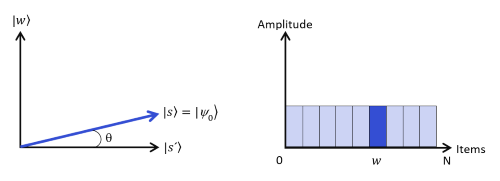

The basic steps of the amplitude amplification process are as follows:

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$. This state is easily created by applying H gates to every qubit. In the graphic above, we denote the angle between \\(|s\rangle\\) and \\(|s'\rangle\\) using \\(\theta\\). Just as we express points on the unit circle, we can write that $$ |s\rangle = \cos(\theta)|s'\rangle + \sin(\theta)|w\rangle$$.

**Step 2**: We then apply the oracle operator, which corresponds to mirroring the state about the \\(|s'\rangle\\) state. Note that this is exactly the same as flipping the phase of the "correct" component and keeping the phases of all other components the same. Some textds denote the oracle operator as \\(U_w\\), as is shown below.

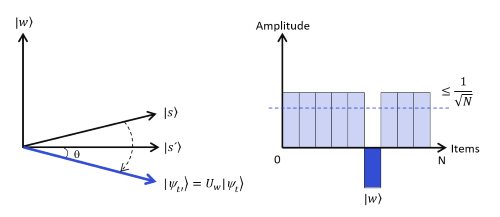

Note that because one of the components is now negative, the average of all the amplitudes is now lower, as shown by the dashed line in the histogram in the figure above. Furthermore, note that the angle between \\(|s\rangle\\) and the reflected state is now \\(2\theta\\)

**Step 3**: We now apply the diffusion operator (sometimes denoted $U_s$), which has the effect of mirroring the state about $|s\rangle$. Now, note that the angle between the doubly reflected state and \\(|s'\rangle\\) is now \\(3\theta\\).

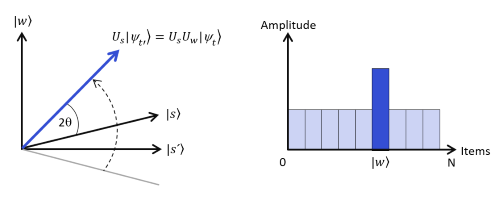

####**Problem #2.2.2**
It turns out that two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner. **Answer the following question on Canvas: Find a function \\(\phi(n)\\) that expresses the angle between a state that has undergone Grover's algorithm and \\(|s\rangle\\) to the number of iterations.**

#### **Problem #2.2.3**
How does this help us calculate the ideal number of iterations? Your answer to the previous question should show that the angle grows linearly as the number of iterations increases, and we also know that ideally, we want to increase the angle until it reaches \\(90^\circ\\), or \\(\frac{\pi}{2}\\) radians. By setting the function found in problem 3.2.3 equal to \(\frac{\pi}{2}\\), we can theoretically solve for \\(n\\), the number of iterations. 

The only thing holding us back is \\(\theta\\), which we don't have an expression for. Suppose our problem only has one correct solution. In this case, we have that the component of the "winner" is \\(\frac{1}{\sqrt{N}}\\), where \\(N\\) is the number of options we are searching through. We also have that the total length of the vector (the hypotenuse of the right triangle formed by the vector and \\(|s\rangle \\)) must be 1, because of the way we constructed \\(|s\rangle\\). We then have the expression $$ \sin\theta = \frac{1}{\sqrt{N}}$$.

However, there is one last key step. When \\(N\\) is reasonably large, \\(\frac{1}{\sqrt{N}}\\) is a very small number, so we can make the approximation that \\(\sin(\theta)\approx\theta\\), which yields \\(\theta \approx \frac{1}{\sqrt{N}}\\). At last, we can solve our equation. **Answer the following question on Canvas: Solve the equation \\(\phi(n)=\frac{\pi}{2}\\), where \\(\phi(n)\\) is the function you found in problem 3.2.2, to find an expression for \\(n\\) in terms of \\(N\\).**

# End of Project

---

© 2023 The Coding School, All rights reserved